# Fine-tuning for Video Classification with 🤗 Transformers

This notebook shows how to fine-tune a pre-trained Vision model for Video Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder and fine-tune the model altogether on a labeled dataset.


## Dataset

This notebook uses a subset of the [UCF-101 dataset](https://www.crcv.ucf.edu/data/UCF101.php). We'll be using a subset of the dataset to keep the runtime of the tutorial short. The subset was prepared using [this notebook](https://drive.google.com/file/d/1tTScjnyiKrBz84jKe1H_hPGGXffAZuxX/view?usp=sharing) following [this guide](https://www.tensorflow.org/tutorials/load_data/video).

## Model

We'll fine-tune the [VideoMAE model](https://huggingface.co/docs/transformers/model_doc/videomae), which was pre-trained on the [Kinetics 400 dataset](https://www.deepmind.com/open-source/kinetics). You can find the other variants of VideoMAE available on 🤗 Hub [here](https://huggingface.co/models?search=videomae). You can also extend this notebook to use other video models such as [X-CLIP](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel).

**Note** that for models where there's no classification head already available you'll have to manually attach it (randomly initialized). But this is not the case for VideoMAE since we already have a [`VideoMAEForVideoClassification`](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel) class.

## Data preprocessing

This notebook leverages [TorchVision's](https://pytorch.org/vision/stable/transforms.html) and [PyTorchVideo's](https://pytorchvideo.org/) transforms for applying data preprocessing transformations including data augmentation.

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In [1]:
batch_size = 4 # batch size for training and evaluation

Before we start, let's install the `pytorchvideo`, `transformers`, and `evaluate` libraries.

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

## Fine-tuning a model on a video classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on a Video Classification dataset.

Given a video, the goal is to predict an appropriate class for it, like "archery".

### Loading the dataset

Here we first download the subset archive and un-archive it.

The warning is telling us we are throwing away some weights (e.g. the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

**Note** that [this checkpoint](https://huggingface.co/MCG-NJU/videomae-base-finetuned-kinetics) leads to better performance on this task as the checkpoint was obtained fine-tuning on a similar downstream task having considerable domain overlap. You can check out [this checkpoint](https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset) which was obtained by fine-tuning `MCG-NJU/videomae-base-finetuned-kinetics` and it obtains much better performance.  

### Constructing the datasets for training

For preprocessing the videos, we'll leverage the [PyTorch Video library](https://pytorchvideo.org/). We start by importing the dependencies we need.

In [2]:
NUM_FRAMES = 16

In [3]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

For the training dataset transformations, we use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, we keep the transformation chain the same except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorch Video](https://pytorchvideo.org).  

We'll use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

In [6]:
import os


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

height = width = 224
resize_to = (height, width)

# num_frames_to_sample = model.config.num_frames
num_frames_to_sample = NUM_FRAMES
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)


# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)



In [12]:
import pandas as pd
df = pd.read_csv('/teamspace/studios/this_studio/video_datasets/video_corpus.csv')
df = df[(df.Language == 'English') & (df.Source=='clean')]

In [16]:
df.head()

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running fau...
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water th...


In [19]:
df.groupby('VideoID').Start.nunique().sort_values(ascending=False)

VideoID
kWLNZzuo3do    22
0lh_UWF9ZP4    20
WTf5EgVY5uU    18
6t0BpjwYKco    16
0hyZ__3YhZc    15
               ..
LwvyrDxM2G0     1
LwicaralvS0     1
Lw0eGsYxElA     1
LuQ0KiMMhoI     1
MHIVmf42Ao4     1
Name: Start, Length: 1534, dtype: int64

In [20]:
df[df.VideoID=='kWLNZzuo3do']

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
15677,kWLNZzuo3do,31,37,682611,clean,114,English,A woman unwraps some foodstuff on a piece of w...
15678,kWLNZzuo3do,31,37,707318,clean,16,English,A woman unwraps food.
15679,kWLNZzuo3do,31,37,280252,clean,41,English,A woman is opening a packet of biscuit.
15680,kWLNZzuo3do,31,37,159786,clean,420,English,A chef opens a food package.
15681,kWLNZzuo3do,31,37,922727,clean,126,English,A woman is unwrapping kamaboko.
...,...,...,...,...,...,...,...,...
110915,kWLNZzuo3do,167,181,772960,clean,995,English,A woman adds starch powder and a little water ...
110916,kWLNZzuo3do,167,181,309959,clean,19,English,The lady seasoned the shrimp in the bowl.
110917,kWLNZzuo3do,167,181,762891,clean,24,English,The woman is seasoning the shrimp.
110918,kWLNZzuo3do,167,181,807872,clean,42,English,A woman puts some seasoning on some worms.


In [ ]:
from pytorchvideo.data import LabeledVideoDataset

class VidCaptionDataset(LabeledVideoDataset):
    def __init__(self,
        labeled_video_paths: List[Tuple[str, Optional[dict]]],
        clip_sampler: ClipSampler,
        video_sampler: Type[torch.utils.data.Sampler] = torch.utils.data.RandomSampler,
        transform: Optional[Callable[[dict], Any]] = None,
        decode_audio: bool = True,
        decoder: str = "pyav"):

        super().__init__(labeled_video_paths=labeled_video_paths,
                            clip_sampler=clip_sampler,
                            video_sampler=video_sampler,
                            transform=transform,
                            decode_audio=decode_audio,
                            decoder=decoder
                            )


In [ ]:
# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [ ]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

Let's now take a preprocessed video from the dataset and investigate it.

In [ ]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [ ]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: Basketball


We can also visualize the preprocessed videos for easier debugging.

In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

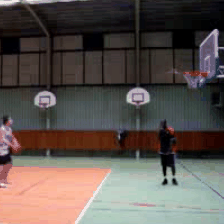

In [ ]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

**Note**: The above dataset pipelines are taken from the [official PyTorch Video example](https://pytorchvideo.org/docs/tutorial_classification#dataset). We're using the [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) function because it's tailored for the UCF-101 dataset. Under the hood, it returns a [`pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.LabeledVideoDataset) object. `LabeledVideoDataset` class is the base class for all things video in the PyTorch Video dataset. So, if you wanted to use a custom dataset not supported off-the-shelf by PyTorch Video, you can extend the `LabeledVideoDataset` class accordingly. Refer to the `data` API [documentation to](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html) learn more. Also, if your dataset follows a similar structure (as shown above), then using the `pytorchvideo.data.Ucf101()` should work just fine.

### Training the model

We'll leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, we will need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [ ]:
from transformers import TrainingArguments, Trainer

# model_name = model_ckpt.split("/")[-1]
model_name = "video_mamba"
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

# args = TrainingArguments(
#     new_model_name,
#     remove_unused_columns=False,
#     evaluation_strategy="steps",
#     eval_steps=10,
#     save_strategy="steps",
#     save_steps = 100,
#     learning_rate=5e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     warmup_ratio=0.1,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     push_to_hub=True,
#     max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
# )

There's no need to define `max_steps` when instantiating `TrainingArguments`. Since the dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__()` method we had to specify `max_steps`.  

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we'll load now. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
from typing import Optional
import torch
from torch import nn
from transformers.modeling_outputs import BaseModelOutput, ImageClassifierOutput
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from videomamba.video_sm.models.videomamba import videomamba_middle, videomamba_small, load_state_dict

class VideoMambaClassification(nn.Module):
    def __init__(self):
        super().__init__()
        # To evaluate GFLOPs, pleaset set `rms_norm=False` and `fused_add_norm=False`
        self.num_labels = len(class_labels)
        self.mamba = videomamba_small(num_frames=NUM_FRAMES, num_classes= self.num_labels)
        state_dict = torch.load("VideoMamba/checkpoints/videomamba_s16_k400_f16_res224.pth", map_location='cpu')
        load_state_dict(self.mamba, state_dict, center=True)

    def forward(self,
        pixel_values: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,):

        logits = self.mamba(pixel_values)
        # print(logits.shape)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            # hidden_states=outputs.hidden_states,
            # attentions=outputs.attentions,
        )
model = VideoMambaClassification()

/teamspace/studios/this_studio/VideoMamba/videomamba/video_sm/models/modeling_finetune.py:330: UserWarning: Overwriting vit_base_patch16_224 in registry with videomamba.video_sm.models.modeling_finetune.vit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_base_patch16_224(pretrained=False, **kwargs):
/teamspace/studios/this_studio/VideoMamba/videomamba/video_sm/models/modeling_finetune.py:339: UserWarning: Overwriting vit_base_patch16_384 in registry with videomamba.video_sm.models.modeling_finetune.vit_base_patch16_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_base_patch16_384(pretrained=False, **kwargs):
/teamspace/studios/this_studio/VideoMamba/videomamba/video_sm/models/modeling_finetune.py:348: UserWarning: Overwriting vit_large_patch16_224 in registry with videomamba.video_sm.models.modeling_finetune.vit_larg

Use checkpoint: False
Checkpoint number: 0
Ignore: head.weight
Ignore: head.bias
_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [ ]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,1.178600,0.842137,0.957143
1,0.201800,0.133671,1.000000
2,0.107300,0.108306,1.000000


KeyboardInterrupt: 

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.10830565541982651, 'eval_accuracy': 1.0}

In [ ]:
# trainer.save_model()
# test_results = trainer.evaluate(test_dataset)
# trainer.log_metrics("test", test_results)
# trainer.save_metrics("test", test_results)
# trainer.save_state()

You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
# trainer.push_to_hub()

events.out.tfevents.1714595899.ip-10-192-11-122.18938.1:   0%|          | 0.00/734 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/thenam/videomae-base-finetuned-ucf101-subset/commit/e74473cc137d23f4a6920eaca01b8cdeb7d47c1f', commit_message='End of training', commit_description='', oid='e74473cc137d23f4a6920eaca01b8cdeb7d47c1f', pr_url=None, pr_revision=None, pr_num=None)

Now that our model is trained, let's use it to run inference on a video from `test_dataset`.

## Inference

Let's load the trained model checkpoint and fetch a video from `test_dataset`.

In [ ]:
# trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name v_ApplyEyeMakeup_g23_c04.avi
video_index 4
clip_index 0
aug_index 0
label 0
Video label: ApplyEyeMakeup


We then prepare the video as a `torch.Tensor` and run inference.

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(model, sample_test_video["video"])

We can now check if the model got the prediction right.

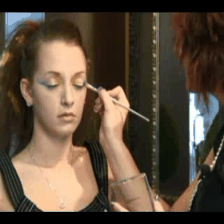

In [ ]:
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

Predicted class: ApplyEyeMakeup


And it looks like it got it right!

You can also use this model to bring in your own videos. Check out [this Space](https://huggingface.co/spaces/sayakpaul/video-classification-ucf101-subset) to know more. The Space will also show you how to run inference for a single video file.

<br><div align=center>
    <img src="https://i.ibb.co/7nW4Rkn/sample-results.gif" width=700/>
</div>

## Next steps

Now that you've learned to train a well-performing video classification model on a custom dataset here is some homework for you:

* Increase the dataset size: include more classes and more samples per class.
* Try out different hyperparameters to study how the model converges.
* Analyze the classes for which the model fails to perform well.
* Try out a different video encoder.

Don't forget to share your models with the community =)